# **Lab experience #8 (SOLUTION): Anomaly Detection using proximity-based approaches**

This eighth lab session aims **to spot anomalies using proximity-based approaches**. This lab session refers to all Prof. Stella's lectures on "Introduction to anomaly detection" and "Nearest neighbor based anomaly detection".

In this lab session, you will **re-use code already developed in the past labs** and discover some new tools from sklearn, particularly [sklearn.neighbors](https://scikit-learn.org/stable/modules/neighbors.html).

**Try two main point-anomaly detection algorithms based on k-th nearest neighborhood**. Idenfity outliers with NN and LOF. Remove them, and then apply clustering (choose one among k-means++, hiearchical clustering, DBSCAN).

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# **Step 1**: Data loading, visual inspection, and scaling

In [ ]:
##### --- 1. LOAD DATA --- ######
# Load the dataset
X = np.load('Dataset_lab08.npy')
[N,M] = np.shape(X)

In [ ]:
# Proximity matrix: to have an idea of how "similar" are the objects in the dataset
from scipy.spatial.distance import pdist as pdist
from scipy.spatial.distance import squareform as sf

distance_metric = 'euclidean'       # You can choose one among the following: 'euclidean', 'minkowski', 'mahalanobis',  'hamming'/'matching', 'jaccard', 'cosine', 'correlation'
PM = pdist(X, metric=distance_metric)
PM = sf(PM).round(2)

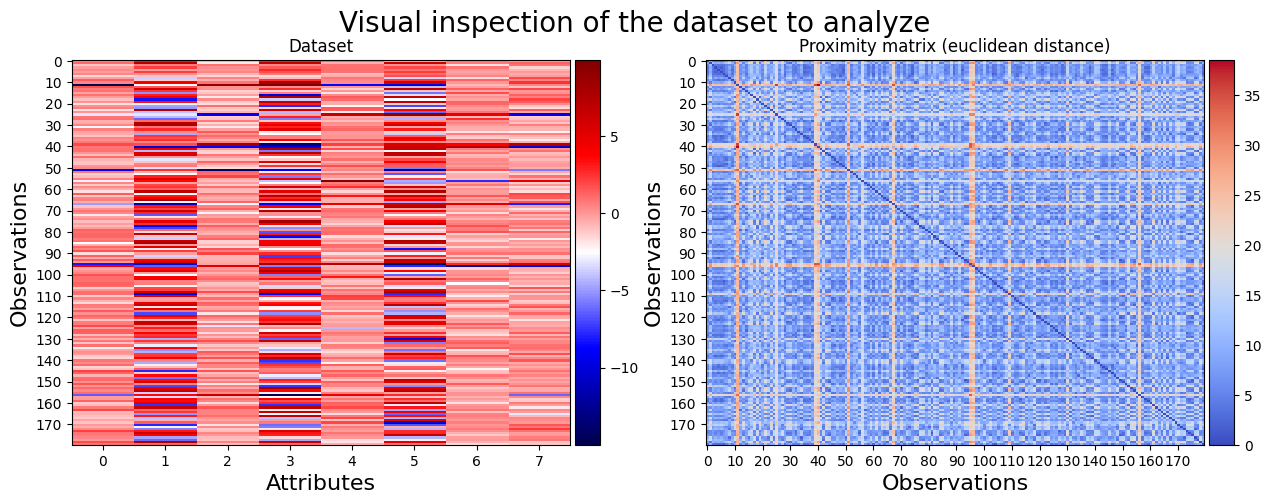

In [ ]:
# Visualization
# -------------
# Choose your preferred style: https://matplotlib.org/stable/gallery/style_sheets/style_sheets_reference.html
plt.style.use('default')

from mpl_toolkits.axes_grid1 import make_axes_locatable   #to adjust the colorbar


fig1 = plt.figure(figsize=(15,5))
fig1.suptitle('Visual inspection of the dataset to analyze', fontsize=20)


# Plot 1: 2D image of the entire dataset
ax1 = fig1.add_subplot(121)
im1 = ax1.imshow(X, interpolation='nearest', aspect='auto', cmap='seismic')

# create an axes on the right side of ax. The width of cax will be 5%
# of ax and the padding between cax and ax will be fixed at 0.05 inch.
divider = make_axes_locatable(ax1)
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im1, cax=cax)

ax1.set_xlabel('Attributes', fontsize=16)
ax1.set_xticks(np.arange(0, M, step=1))
ax1.set_ylabel('Observations', fontsize=16)
ax1.set_yticks(np.arange(0, N, step=10))
ax1.title.set_text('Dataset')


# Plot 2: proximity matrix
ax2 = fig1.add_subplot(122)
im2 = ax2.imshow(PM, interpolation='nearest', aspect='auto', cmap='coolwarm')

divider = make_axes_locatable(ax2)
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im2, cax=cax)

ax2.set_xlabel('Observations', fontsize=16)
ax2.set_xticks(np.arange(0, N, step=10))
ax2.set_ylabel('Observations', fontsize=16)
ax2.set_yticks(np.arange(0, N, step=10))
ax2.title.set_text('Proximity matrix (%s distance)' % distance_metric)

plt.show()

Comment: from a very first visual inspection, you can immediately see that some data points are quite far away from the majority of the others. Then, you might expect some outliers are there.

_Note. For the proximity matrix, euclidean distance has been computed. Why not correlation? Try yourself.._


**General purpose comment.** Be careful not to consider any "minor behaviour" (i.e., different from the majority) as an outlier. In this specific case, (1) the lab is on outliers detection 😉 and (2) the number of data points with "minor behaviour" is very small compared to the majority, then you might expect that those points are actually outliers.

# Preprocessing: scaling

**General purpose comment.** Be careful not to _blindly_ scale, with the same scaler, attributes of different types (e.g., Normalizer() might be good for binary 0-1 attributes, MinMaxScaler() might not be good for them as well..).

In the following, it is assumed that you have checked the type of the attributes of the dataset and, since all of them are continuous, you can apply the same scaling/normalization.

In [ ]:
##### --- 2. SCALING --- ######
# Initialize the scaler you want to use: MinMaxScaler(), StandardScaler(), RobustScaler(), Normalizer()
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, Normalizer
scaler = RobustScaler()

# Apply the scaling to data
X_transformed = scaler.fit_transform(X)

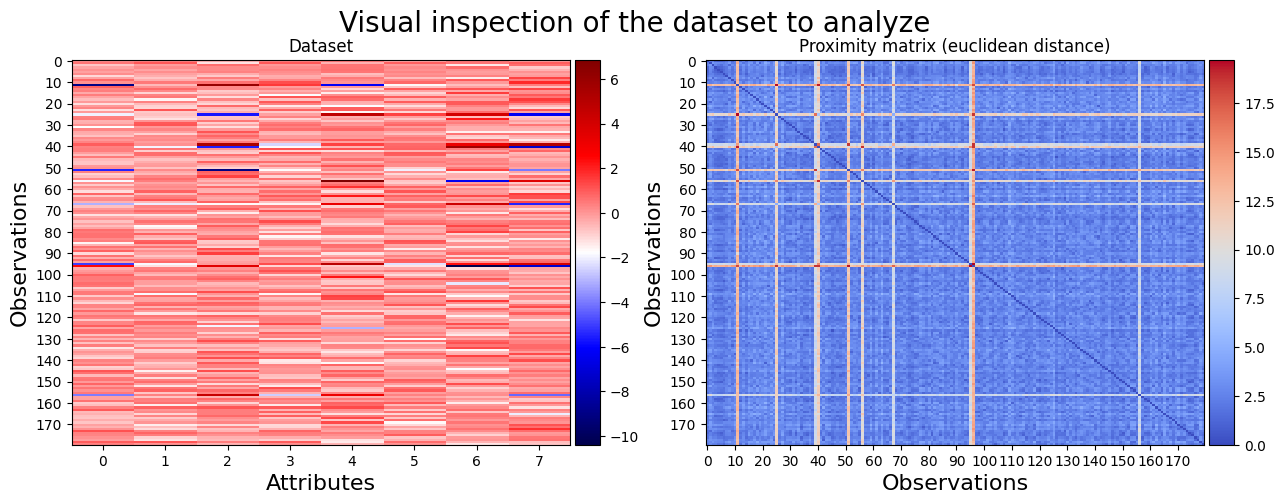

In [ ]:
# Proximity matrix after scaling
# ------------------------------
PM_transformed = pdist(X_transformed, metric=distance_metric)
PM_transformed = sf(PM_transformed).round(2)



# Visualization after scaling
# ---------------------------
# Choose your preferred style: https://matplotlib.org/stable/gallery/style_sheets/style_sheets_reference.html
plt.style.use('default')

from mpl_toolkits.axes_grid1 import make_axes_locatable   #to adjust the colorbar


fig2 = plt.figure(figsize=(15,5))
fig2.suptitle('Visual inspection of the dataset to analyze', fontsize=20)


# Plot 1: 2D image of the entire dataset
ax1 = fig2.add_subplot(121)
im1 = ax1.imshow(X_transformed, interpolation='nearest', aspect='auto', cmap='seismic')

# create an axes on the right side of ax. The width of cax will be 5%
# of ax and the padding between cax and ax will be fixed at 0.05 inch.
divider = make_axes_locatable(ax1)
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im1, cax=cax)

ax1.set_xlabel('Attributes', fontsize=16)
ax1.set_xticks(np.arange(0, M, step=1))
ax1.set_ylabel('Observations', fontsize=16)
ax1.set_yticks(np.arange(0, N, step=10))
ax1.title.set_text('Dataset')


# Plot 2: proximity matrix
ax2 = fig2.add_subplot(122)
im2 = ax2.imshow(PM_transformed, interpolation='nearest', aspect='auto', cmap='coolwarm')

divider = make_axes_locatable(ax2)
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im2, cax=cax)

ax2.set_xlabel('Observations', fontsize=16)
ax2.set_xticks(np.arange(0, N, step=10))
ax2.set_ylabel('Observations', fontsize=16)
ax2.set_yticks(np.arange(0, N, step=10))
ax2.title.set_text('Proximity matrix (%s distance)' % distance_metric)

plt.show()

_Note._ If you have applied Normalizer(), you might have experienced that no outliers are visible anymore. This is not a good point. Be careful to apply such scaling operator, and remember that (from documentation) "each sample (i.e. each row of the data matrix) with at least one non zero component is rescaled independently of other samples so that its norm (l1, l2 or inf) equals one." Then, if the dataset includes outliers, they are also rescaled to have norm=1 on its row, _artefactually_ making the outlier appearing as one "normal" data point.

# **Step 2**: Investigation on outliers using Nearest Neighbors (NN)



Hint:

[NN](https://scikit-learn.org/stable/modules/neighbors.html) see section 1.6.1.1. "Finding the Nearest Neighbors" and also check previous lab solutions (e.g., Lab7)

```
i. compute distance of all data points to their k-th neighbors (d_k)
ii. sort the d_k distances in ascending order
iii. compute the average (or median) distance among all d_k distances
iv. the top n% data points having d_k largest are defined as outliers

Hyperparameters to set:
k = order of the neighborhood
n = percentage of data points (over the entire dataset) expected to be outliers.
```

**Steps:**
- Apply the algorithm
- Apply the outlier discovery method, count the outliers, and label them.
- Remove the outliers from the dataset, obtaining a reduced dataset (X_red_NN).

[161, 1.92]


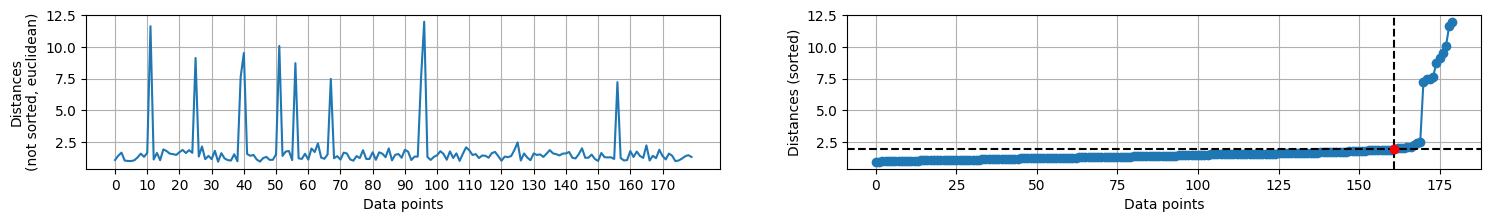

In [ ]:
# Apply the algorithm
from sklearn.neighbors import NearestNeighbors as knn
neighborhood_order = 5

# Find neighborhood
neighborhood_set   = knn(n_neighbors=neighborhood_order, algorithm='ball_tree').fit(X_transformed)
distances, indices = neighborhood_set.kneighbors(X_transformed)

# compute distances from 5th nearest neighbors and sort them
dk_sorted     = np.sort(distances[:,-1])
dk_sorted_ind = np.argsort(distances[:,-1])


# Identify the outliers as those points with too high distance from their own 5th nearest neighbor
# !pip install kneed                   # run this line only the first time you run this cell
from kneed import KneeLocator
i = np.arange(len(distances))
knee = KneeLocator(i, dk_sorted, S=1, curve='convex', direction='increasing', interp_method='interp1d', online=True)     # see other examples: https://kneed.readthedocs.io/en/stable/parameters.html
'''
S - The sensitivity parameter allows us to adjust how aggressive we want Kneedle to be when detecting knees.
    Smaller values for S detect knees quicker, while larger values are more conservative.
    Put simply, S is a measure of how many “flat” points we expect to see in the unmodified data curve before declaring a knee.
'''
knee_x = knee.knee
knee_y = knee.knee_y    # OR: distances[knee.knee]

print([knee_x, np.round(knee_y,2)])


# Plot distances
fig3 = plt.figure(figsize=(18,2))

ax1 = fig3.add_subplot(121)
plt.plot(distances[:,-1])
ax1.set_xlabel('Data points', fontsize=10)
ax1.set_xticks(np.arange(0, N, step=10))
ax1.set_ylabel('Distances\n(not sorted, %s)' % distance_metric, fontsize=10)
# ax1.title.set_text('Proximity matrix (%s distance)' % distance_metric)
plt.grid()

ax2 = fig3.add_subplot(122)
plt.plot(dk_sorted, 'o-')
ax2.set_xlabel('Data points', fontsize=10)
ax2.set_ylabel('Distances (sorted)', fontsize=10)
plt.axvline(x=knee_x, color='k', linestyle='--')
plt.axhline(y=knee_y, color='k', linestyle='--')
plt.plot((knee_x), (knee_y), 'o', color='r')
plt.grid()

plt.show()

In [ ]:
# Verify the outlier detection, count and label the outliers

# Note. Here, you have 3 different methods and check the different results:
# 1: use the knee point                                 --> knee_x, knee_y
# 2: decide a percentage of outliers a-priori (n%)      --> n = 1%
# 3: use a threshold from the above plot, left panel    --> dk_th = 5

#1
id_points2remove = dk_sorted_ind[knee_x:]
id1_sorted       = np.sort(id_points2remove)
print(id1_sorted)
count1 = len(id1_sorted)
print(count1)
NN_labels1 = np.ones(N)
NN_labels1[id1_sorted] = -1

#2
n = 0.05
Q = np.ceil(N*n).astype(int)
id_points2remove = dk_sorted_ind[-Q:]
id1_sorted       = np.sort(id_points2remove)
print(id1_sorted)
count2 = len(id1_sorted)
print(count2)
NN_labels2 = np.ones(N)
NN_labels2[id1_sorted] = -1


#3
dk_th = 5
id_points2remove = dk_sorted_ind[np.where(dk_sorted>=dk_th)]
id1_sorted       = np.sort(id_points2remove)
print(id1_sorted)
count3 = len(id1_sorted)
print(count3)
NN_labels3 = np.ones(N)
NN_labels3[id1_sorted] = -1

[ 11  15  25  27  39  40  51  56  61  63  67  85  95  96 109 125 145 156
 165]
19
[11 25 39 40 51 56 67 95 96]
9
[ 11  25  39  40  51  56  67  95  96 156]
10


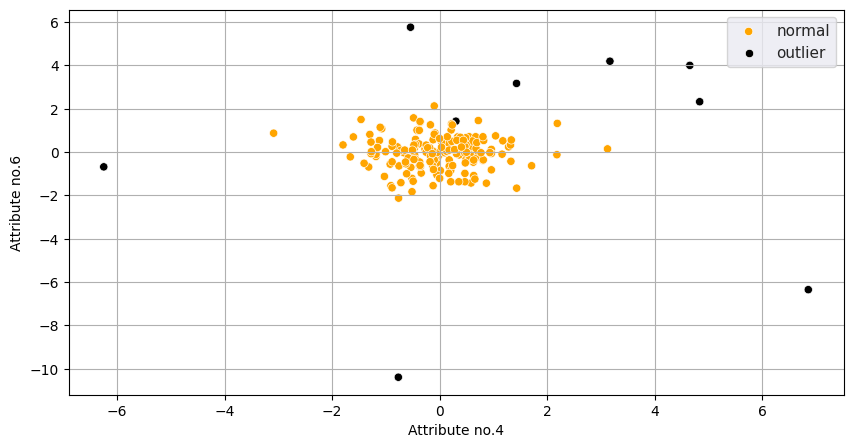


Applyting tSNE...
[t-SNE] Computing 179 nearest neighbors...
[t-SNE] Indexed 180 samples in 0.001s...
[t-SNE] Computed neighbors for 180 samples in 0.255s...
[t-SNE] Computed conditional probabilities for sample 180 / 180
[t-SNE] Mean sigma: 1.590196
[t-SNE] KL divergence after 250 iterations with early exaggeration: 37.659576
[t-SNE] KL divergence after 300 iterations: 0.209677


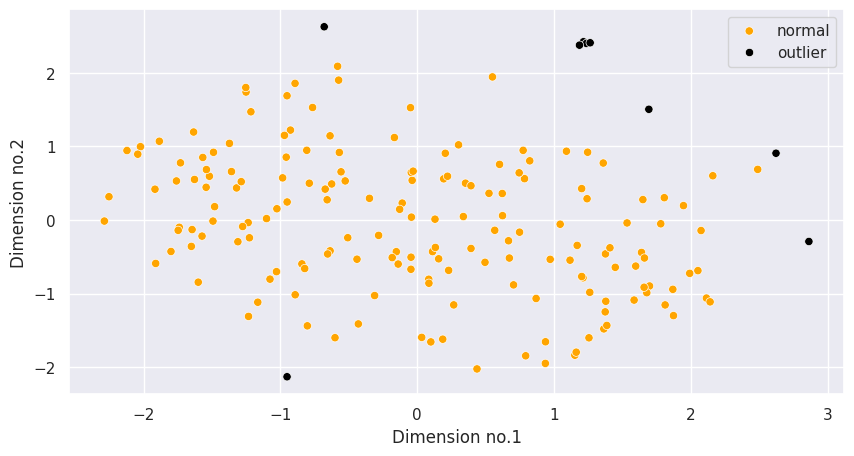

PCA: explained variation per principal component: [0.28 0.19 0.15]


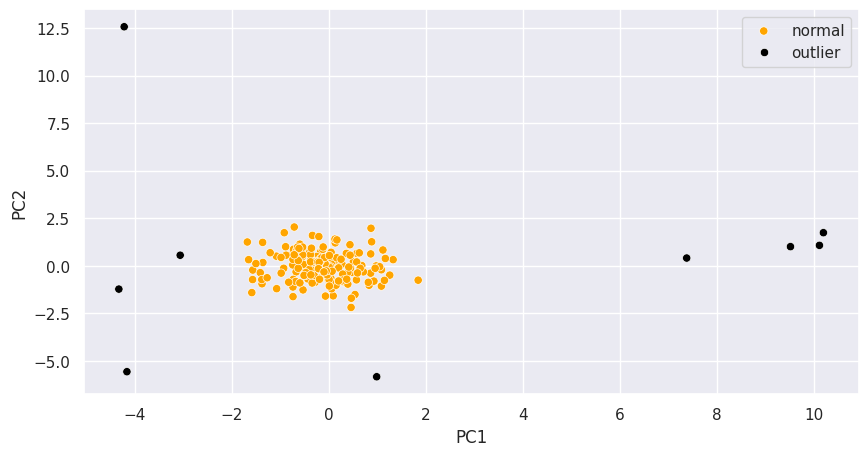

In [ ]:
labels2use = NN_labels2

# Scatterplot (black points are the outliers)
# -------------------------------------------
feat1 = 4
feat2 = 6
fig4 = plt.figure('Check the dataset (2 random attributes)', figsize=(10,5))
sns.scatterplot( x = X_transformed[:,feat1], y = X_transformed[:,feat2], hue=labels2use, palette=['black','orange'])
sns.set_theme(style='dark')
plt.xlabel('Attribute no.%s' % feat1)
plt.ylabel('Attribute no.%s' % feat2)
plt.legend(['normal','outlier'])
plt.grid()
plt.show()

# tSNE
from sklearn.manifold import TSNE
print('\nApplyting tSNE...')
tsne = TSNE(n_components=2, verbose=1, perplexity=100, n_iter=300)
tsne_results = tsne.fit_transform(X_transformed)

fig5 = plt.figure('Check the dataset (tSNE)', figsize=(10,5))
sns.scatterplot( x = tsne_results[:,0], y = tsne_results[:,1], hue=labels2use, palette=['black','orange'])
sns.set_theme(style='dark')
plt.xlabel('Dimension no.1')
plt.ylabel('Dimension no.2')
plt.legend(['normal','outlier'])
plt.grid()
plt.show()


# PCA
from sklearn.decomposition import PCA
pca = PCA(n_components=3)
pca_result = pca.fit_transform(X_transformed)
print('PCA: explained variation per principal component: {}'.format(pca.explained_variance_ratio_.round(2)))

fig6 = plt.figure('Check the dataset (PCA)', figsize=(10,5))
sns.scatterplot( x = pca_result[:,0], y = pca_result[:,1], hue=labels2use, palette=['black','orange'])
sns.set_theme(style='dark')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend(['normal','outlier'])
plt.grid()
plt.show()

In [ ]:
# Remove rows containing outliers, obtaining X_red_NN
# labels2use = NN_labels2
X_red_NN = np.delete(X_transformed, [np.where(labels2use==-1)], axis=0)

# **Step 3**: Investigation on outliers using Local Outlier Factor (LOF)


Hint:

[LOF](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.LocalOutlierFactor.html#sklearn.neighbors.LocalOutlierFactor) [and also slide no.8 and [WIki](https://en.wikipedia.org/wiki/Local_outlier_factor)]. Here, you don't have to manually implement the algorithm, but only to correctly use the sklearn package to obtain LOF.

```
Locality is given by k-nearest neighbors, whose distance is used to estimate the local density. By comparing the local density of a sample to the local densities of its neighbors, one can identify samples that have a substantially lower density than their neighbors.
These are considered outliers.

For each data point (A) compute the distance to the kth nearest neighbor (d_k)

i. identify the k-th neighborhood of the data point A. Note: for each data point A, you will find a |N_k(A)| points in its k-th neighborhood (|N_k(A)| is indicated as MinPts in Prof. Stella's slides).
ii. compute the average reachability distance to A (average reach_dist_k_AB across all neighbors of A in N_k(A)).
iii. compute the local reachability density (lrd_k) of data point A as the inverse of the average reach_dist_k_AB.
iv. compute LOF(A) as the ratio of the average local reachability density of A's k-nearest neighbors and local reachability density of the data point A.

Hyperparameters to set:
n_neighbors = number of neighbors to consider in N_k(A)
metric = 'minkowski' (with p = 2) as default (i.e., euclidean metric)
contamination = the proportion of outliers expected in the data set.

Possible outputs:
A has LOF < 1, then A is inlier
A has LOF > 1, then A is outlier (the contamination parameter helps you defining the threshold here)
A has LOF near 1, then A has density similar to its neighbors.



Actually, from the sklearn.neighbors.LocalOutlierFactor documentation:
"The opposite LOF of the training samples. The higher, the more normal.
Inliers tend to have a LOF score close to 1 (negative_outlier_factor_ close to -1),
while outliers tend to have a larger LOF score.".
```

**Steps:**


- Apply the algorithm. Read [documentation.](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.LocalOutlierFactor.html#sklearn.neighbors.LocalOutlierFactor) Particularly,

```
contamination = ‘auto’ or float, default=’auto’
is the amount of contamination of the data set, i.e. the proportion of outliers in the data set.
If ‘auto’, the threshold is determined as in the original paper.
If a float, the contamination should be in the range (0, 0.5].
```

- Apply the outlier discovery method, count the outliers, and label them.
- Remove the outliers from the dataset, obtaining a reduced dataset (X_red_LOF).

In [ ]:
# Apply the algorithm
from sklearn.neighbors import LocalOutlierFactor

lof_model  = LocalOutlierFactor(n_neighbors  = neighborhood_order,
                                algorithm='ball_tree',
                                metric='minkowski', p=2,
                                metric_params = None,
                                contamination = n)
# dir(lof_model)
LOF_labels = lof_model.fit_predict(X_transformed)     # predict the labels (1 inlier, -1 outlier) of X according to LOF
# dir(lof_model)
LOF_values     = lof_model.negative_outlier_factor_
# print(np.round(LOF_values,2))

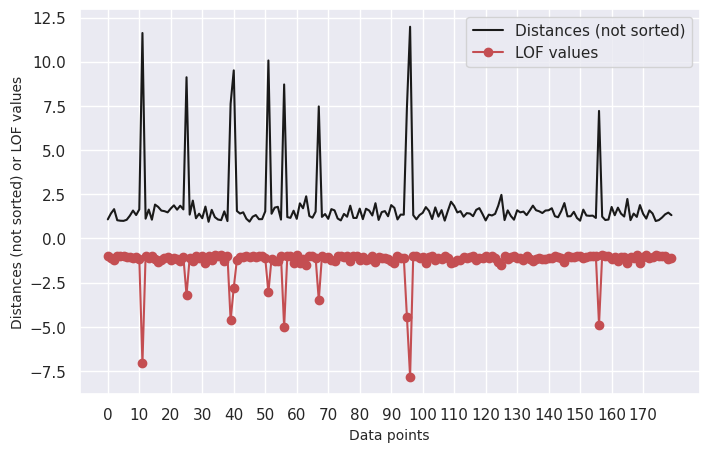

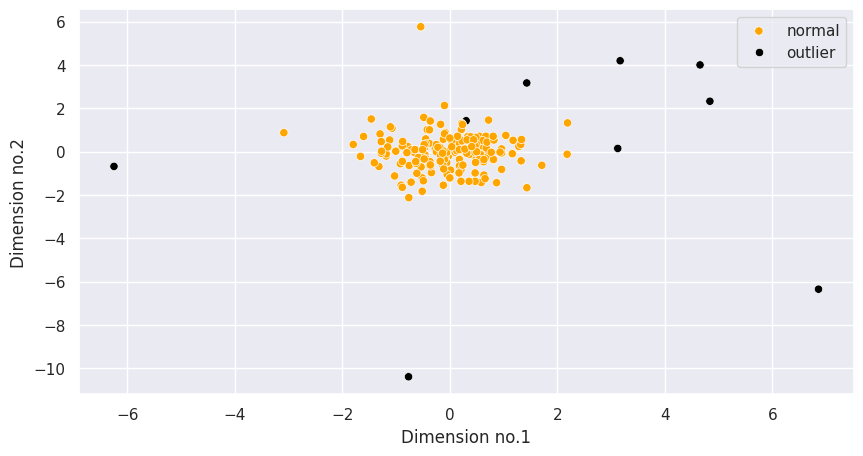

9


In [ ]:
# Verify the outlier detection, count and label the outliers
fig6 = plt.figure('LOF values', figsize=(8,5))
plt.plot(distances[:,-1], 'k-')
plt.xlabel('Data points', fontsize=10)
plt.xticks(np.arange(0, N, step=10))
plt.ylabel('Distances (not sorted) or LOF values', fontsize=10)
plt.plot(LOF_values, 'ro-')
plt.legend(["Distances (not sorted)", "LOF values"])
plt.grid()
plt.show()

fig7 = plt.figure('Scatterplot with the LOF method', figsize=(10,5))
sns.scatterplot( x = X_transformed[:,feat1], y = X_transformed[:,feat2], hue=LOF_labels, palette=['black','orange'])
# sns.scatterplot( x = tsne_results[:,0], y = tsne_results[:,1], hue=LOF_labels, palette=['black','orange'])
# sns.scatterplot( x = pca_results[:,0], y = pca_results[:,1], hue=LOF_labels, palette=['black','orange'])
sns.set_theme(style='dark')
plt.xlabel('Dimension no.1')
plt.ylabel('Dimension no.2')
plt.legend(['normal','outlier'])
plt.grid()
plt.show()


# Count
count4 = len(LOF_labels[LOF_labels==-1])
print(count4)

In [ ]:
# Remove rows containing outliers, obtaining X_red_LOF
labels2use = LOF_labels
X_red_LOF = np.delete(X_transformed, [np.where(labels2use==-1)], axis=0)

# **Step 4**: Check coherence between the two outlier detection methods

**Steps:**
- visualize outliers given by NN and by LOF in the same plot
- compute Rand index on labels

Homogeneity: 0.740
Completeness: 0.740
V-measure: 0.740
Adjusted Rand Index: 0.872
Adjusted Mutual Information: 0.737


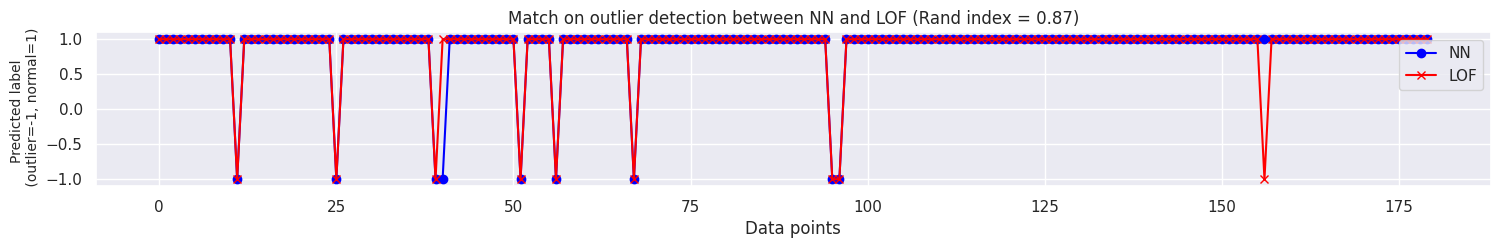

In [ ]:
y1 = NN_labels2
y2 = LOF_labels

from sklearn import metrics
print(f"Homogeneity: {metrics.homogeneity_score(y1, y2):.3f}")
print(f"Completeness: {metrics.completeness_score(y1, y2):.3f}")
print(f"V-measure: {metrics.v_measure_score(y1, y2):.3f}")
R = metrics.adjusted_rand_score(y1, y2)
print(f"Adjusted Rand Index: {R:.3f}")
print("Adjusted Mutual Information:" f" {metrics.adjusted_mutual_info_score(y1, y2):.3f}")


# Visually inspect the match between the outliers found by the NN and LOF
fig20 = plt.figure('Comparison spotted outliers', figsize=(18,2))
plt.plot(y1, color='blue', marker="o", label='NN')
plt.plot(y2, color='red', marker="x", label='LOF')
plt.xlabel('Data points')
plt.ylabel('Predicted label \n (outlier=-1, normal=1)', fontsize=10)
plt.title('Match on outlier detection between NN and LOF (Rand index = %.2f)' %R)
plt.legend(["NN", "LOF"])
plt.grid()
plt.show()

**Comment:** you can try to change the labelling given by NN (i.e., labels1, labels2, labels3). You will find out that NN with labels3 has the highest match with the LOF method (i.e., the highest Rand index).

# [NEW] **Step 5**: Supervised validation (using TRUE labels)

**Steps:**
- visualize outliers given by NN, by LOF and TRUE labels in the same plot
- compute Rand index between each method and the TRUE labels

In [ ]:
# Extract the indeces of outliers from the true labels
TRUElabels = np.load('TRUElabels_lab08.npy')
true_outliers = np.ones(N)
true_outliers[np.where(TRUElabels==-1)] = -1

In [ ]:
print(np.unique(TRUElabels))

[-1  0  1  2]


In the dataset, there are 3 clusters and some outliers. However, clusters are not so well-separated.

PCA: explained variation per principal component: [0.29 0.16]

Applying tSNE...


<ipython-input-56-76933469a680>:40: UserWarning: The palette list has more values (4) than needed (3), which may not be intended.
  sns.scatterplot(x=pca_result[:,0], y=pca_result[:,1], ax=ax1, hue=LABELS, palette=PAL)
<ipython-input-56-76933469a680>:47: UserWarning: The palette list has more values (4) than needed (3), which may not be intended.
  sns.scatterplot(x=tsne_results[:,0], y=tsne_results[:,1], ax=ax2, hue=LABELS, palette=PAL)


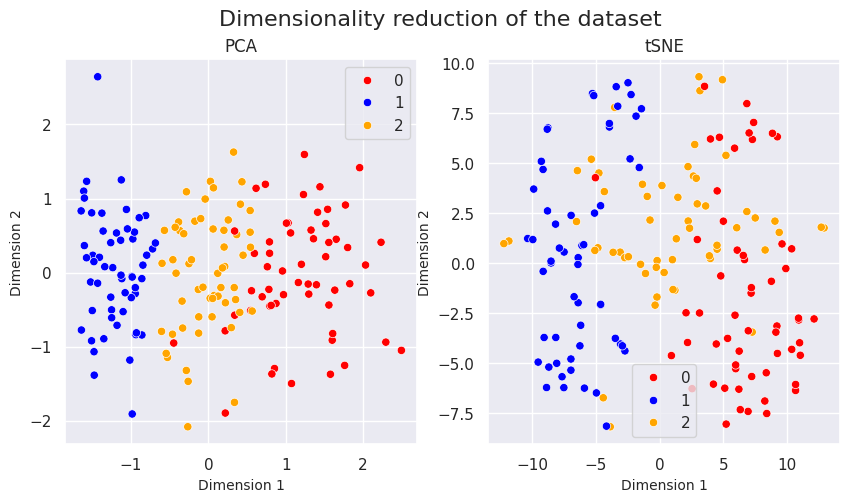

In [ ]:
# Clean dataset
X_red_TRUE = np.delete(X_transformed, [np.where(TRUElabels==-1)], axis=0)    # only good samples (excluding outliers)
GOODlabels = np.delete(TRUElabels, np.where(TRUElabels==-1) )                # true labels only as good samples
PCA_tSNE_visualization(X_red_TRUE, 2, GOODlabels, PAL)                       # groups of good samples

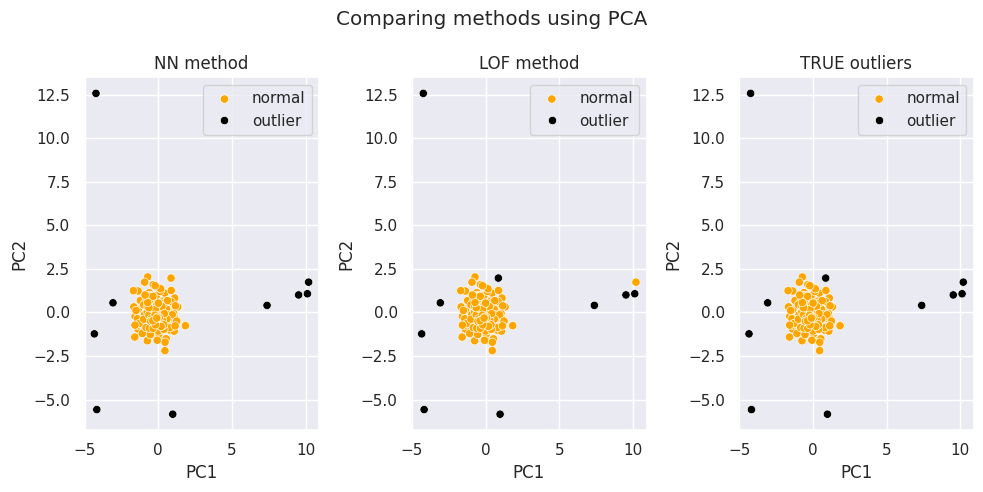

In [ ]:
# Comparison of outliers detection among methods using PCA
fig30, axs = plt.subplots( 1, 3, figsize=(10,5))
fig30.suptitle('Comparing methods using PCA')


# NN
sns.scatterplot( x = pca_result[:,0], y = pca_result[:,1], hue=NN_labels2, palette=['black','orange'], ax=axs[0])
sns.set_theme(style='dark')
axs[0].set_title("NN method")

# LOF
sns.scatterplot( x = pca_result[:,0], y = pca_result[:,1], hue=LOF_labels, palette=['black','orange'], ax=axs[1])
sns.set_theme(style='dark')
axs[1].set_title("LOF method")


# TRUE labels
sns.scatterplot( x = pca_result[:,0], y = pca_result[:,1], hue=true_outliers, palette=['black','orange'], ax=axs[2])
sns.set_theme(style='dark')
axs[2].set_title("TRUE outliers")


# Common settings for subplots
for ax in axs.flat:
    ax.set(xlabel='PC1', ylabel='PC2')
    ax.legend(['normal','outlier'])
    ax.grid()


plt.tight_layout()
plt.show()

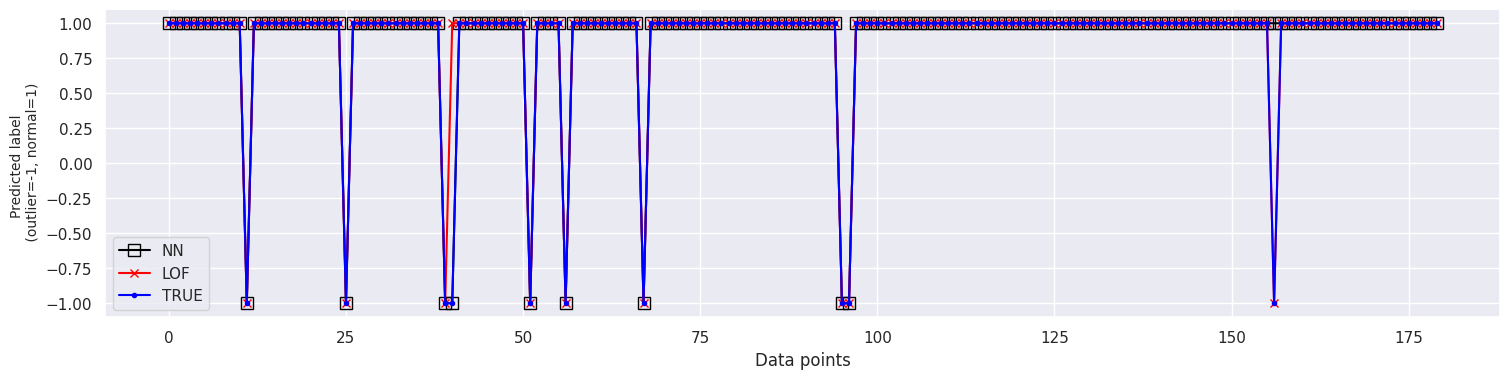

In [ ]:
# Visually inspect the match between the outliers found by the NN, LOF, and TRUE outliers
fig21 = plt.figure('Comparison spotted outliers', figsize=(18,4))
plt.plot(y1, color='black', marker="s", markersize=8, markerfacecolor='none', markeredgecolor='black', label='NN')
plt.plot(y2, color='red', marker="x", markersize=6, label='LOF')
plt.plot(true_outliers, color='blue', marker="o", markersize=3, label='TRUE')
plt.xlabel('Data points')
plt.ylabel('Predicted label \n (outlier=-1, normal=1)', fontsize=10)
plt.legend(["NN", "LOF", "TRUE"])
plt.grid()
plt.show()

In [ ]:
# NN vs TRUE outliers
print("NN-based outlier detection:")
print(f"Homogeneity: {metrics.homogeneity_score(y1, true_outliers):.3f}")
print(f"Completeness: {metrics.completeness_score(y1, true_outliers):.3f}")
print(f"V-measure: {metrics.v_measure_score(y1, true_outliers):.3f}")
print(f"Adjusted Rand Index: {metrics.adjusted_rand_score(y1, true_outliers):.3f}")
print("Adjusted Mutual Information:" f" {metrics.adjusted_mutual_info_score(y1, true_outliers):.3f}")

NN-based outlier detection:
Homogeneity: 0.909
Completeness: 0.841
V-measure: 0.874
Adjusted Rand Index: 0.939
Adjusted Mutual Information: 0.872


In [ ]:
# LOF vs TRUE outliers
print("LOF-based outlier detection:")
print(f"Homogeneity: {metrics.homogeneity_score(true_outliers, y2):.3f}")
print(f"Completeness: {metrics.completeness_score(true_outliers, y2):.3f}")
print(f"V-measure: {metrics.v_measure_score(true_outliers, y2):.3f}")
print(f"Adjusted Rand Index: {metrics.adjusted_rand_score(true_outliers, y2):.3f}")
print("Adjusted Mutual Information:" f" {metrics.adjusted_mutual_info_score(true_outliers, y2):.3f}")

LOF-based outlier detection:
Homogeneity: 0.841
Completeness: 0.909
V-measure: 0.874
Adjusted Rand Index: 0.939
Adjusted Mutual Information: 0.872


# **Step 6**: Apply clustering (hierarchical, k-means, or DBSCAN)

Here, apply clustering on X and on X_red (X_red_NN or X_red_LOF) to see the effect of outliers on clustering.

In [ ]:
# Define a palette
PAL = ['red', 'blue', 'orange', 'green', 'magenta']

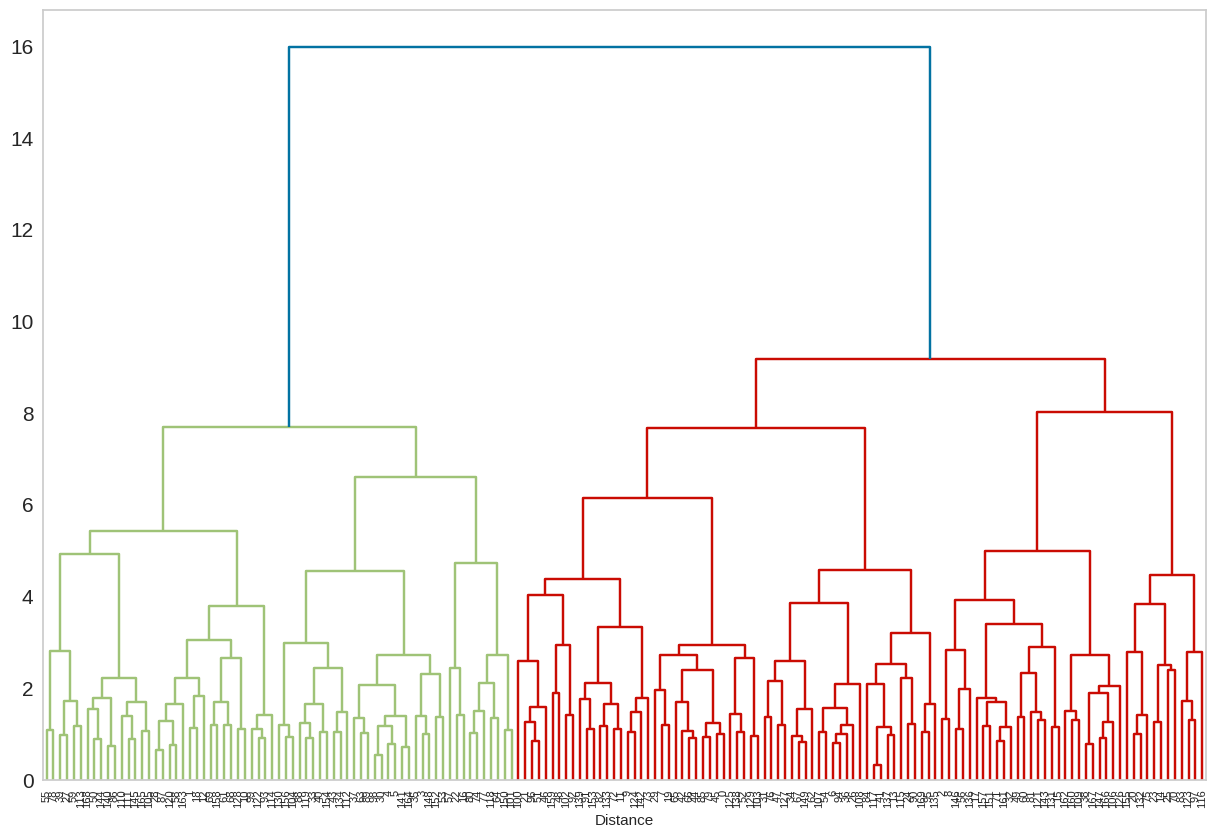

In [ ]:
# Clustering: hierarchical
from scipy.cluster import hierarchy
from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import fcluster

method_merging = 'ward'
distance_metric = 'euclidean'

# TRY HERE TO SUBSTITUTE: X_transformed, X_red_TRUE, X_red_NN, X_red_LOF
Z = hierarchy.linkage(X_red_TRUE, method_merging, metric=distance_metric, optimal_ordering='true')

fig4 = plt.figure(figsize=(15, 10))
dn = hierarchy.dendrogram(Z, no_plot=0)
plt.tick_params(axis='y', which='major', labelsize=15)
plt.tick_params(axis='x', which='major', labelsize=8)
plt.xlabel('Distance')
plt.grid()
plt.show()

**Note** If you change the dataset (X_transformed, X_red_TRUE, X_red_NN, X_red_LOF), you will notice that the hierarchical clustering algorithm puts some outliers in separate clusters. Also, in X_red_NN and X_red_LOF, where one outlier was mis-identified, the clustering results in one singleton cluster.

In [ ]:
# Cut the forest
max_d = 9

# Form the clusters
labels = fcluster(Z, max_d, criterion='distance')

print(labels.shape)
print(labels)

# Obtain the number of clusters
K = labels.max()
print("We got %d cluster(s)." % K)

(170,)
[2 1 3 1 1 1 2 2 3 2 1 2 1 2 3 3 1 3 1 2 3 2 1 3 2 3 2 1 1 2 1 2 3 1 2 1 2
 1 3 1 1 2 2 1 2 2 2 2 2 3 1 2 2 1 2 1 3 1 1 1 3 1 2 1 1 2 2 2 1 1 3 3 2 2
 1 3 2 1 1 2 1 3 2 3 2 2 1 1 1 1 2 2 2 1 2 2 2 3 1 1 2 1 2 2 1 1 3 2 2 3 1
 1 1 1 1 2 3 2 1 1 1 3 1 3 2 2 3 2 1 2 1 3 3 2 1 2 3 2 2 2 1 1 2 3 1 1 3 3
 1 2 1 3 1 2 1 3 1 3 1 2 3 3 3 1 1 1 3 3 1 2]
We got 3 cluster(s).


PCA: explained variation per principal component: [0.29 0.16]

Applying tSNE...


<ipython-input-56-76933469a680>:40: UserWarning: The palette list has more values (5) than needed (3), which may not be intended.
  sns.scatterplot(x=pca_result[:,0], y=pca_result[:,1], ax=ax1, hue=LABELS, palette=PAL)
<ipython-input-56-76933469a680>:47: UserWarning: The palette list has more values (5) than needed (3), which may not be intended.
  sns.scatterplot(x=tsne_results[:,0], y=tsne_results[:,1], ax=ax2, hue=LABELS, palette=PAL)


<Figure size 1800x400 with 0 Axes>

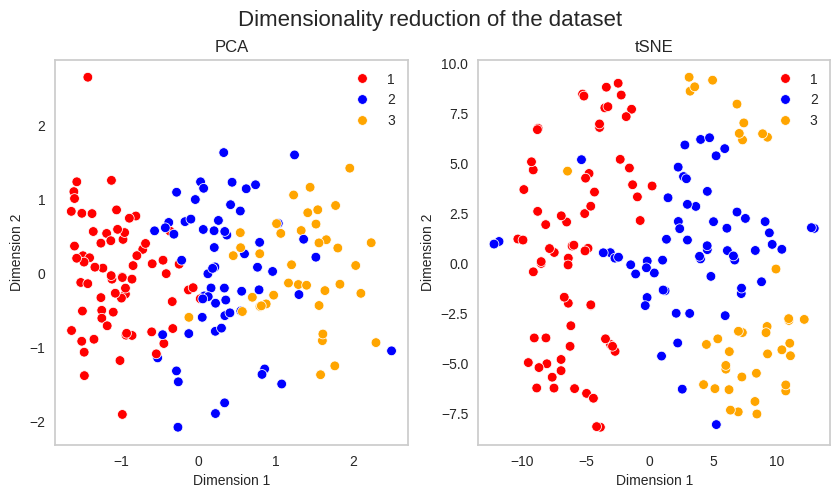

In [ ]:
# Visualization
fig100 = plt.figure(figsize=(18,4))
PCA_tSNE_visualization(X_red_TRUE, 2, labels, PAL)

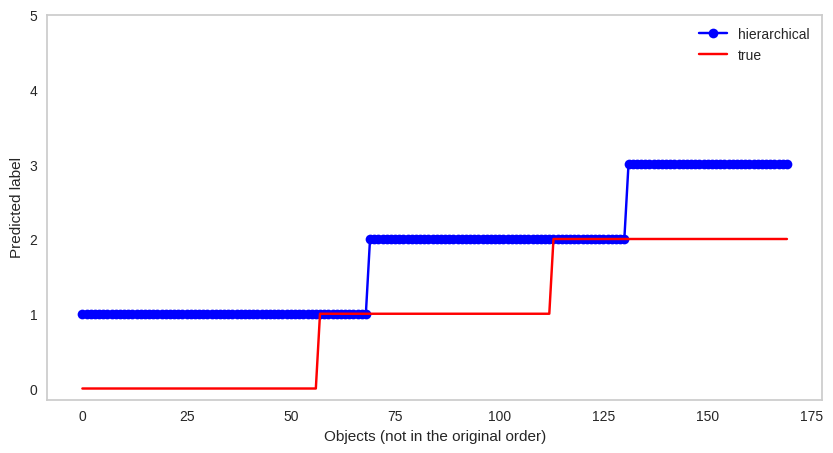

In [97]:
y1 = np.sort(labels)   # predicted labels from hierarchical clustering
y2 = np.sort(GOODlabels)     # predicted labels from k-means clustering

fig101 = plt.figure('Comparison of predicted labels', figsize=(10,5))
plt.plot(y1, color='blue', marker="o", label='hierarchical')
plt.plot(y2, color='red', marker="x", label='true')
plt.xlabel('Objects (not in the original order)')
plt.yticks(np.arange(0,6))
plt.ylabel('Predicted label')
plt.legend()
plt.grid()
plt.show()

In [96]:
# Validation: hierarchical clustering labels vs GOOD labels
print("hierarchical clustering labels vs GOOD labels:")
print(f"Homogeneity: {metrics.homogeneity_score(GOODlabels, labels):.3f}")
print(f"Completeness: {metrics.completeness_score(GOODlabels, labels):.3f}")
print(f"V-measure: {metrics.v_measure_score(GOODlabels, labels):.3f}")
print(f"Adjusted Rand Index: {metrics.adjusted_rand_score(GOODlabels, labels):.3f}")
print("Adjusted Mutual Information:" f" {metrics.adjusted_mutual_info_score(GOODlabels, labels):.3f}")

hierarchical clustering labels vs GOOD labels:
Homogeneity: 0.645
Completeness: 0.519
V-measure: 0.513
Adjusted Rand Index: 0.579
Adjusted Mutual Information: 0.507


# Utility functions

In [ ]:
# [FROM SOLUTION OF LAB#4] THIS IS A **METHOD** THAT YOU CAN USE IN THE NEXT LAB SESSIONS TO find visualize data in 2D with clusters in different colours

def PCA_tSNE_visualization(data2visualize, NCOMP, LABELS, PAL):

  '''
  INPUT
  data2visualize    - data matrix to visualize
  NCOMP             - no. of components to decompose the dataset during PCA
  LABELS            - labels given by the clustering solution
  PAL               - palette of colours to distinguish between clusters
  '''

  '''
  OUTPUT
  Two figures: one using PCA and one using tSNE
  '''


  # PCA
  from sklearn.decomposition import PCA
  pca = PCA(n_components=NCOMP)
  pca_result = pca.fit_transform(data2visualize)
  print('PCA: explained variation per principal component: {}'.format(pca.explained_variance_ratio_.round(2)))

  # tSNE
  from sklearn.manifold import TSNE
  print('\nApplying tSNE...')
  np.random.seed(100)
  tsne = TSNE(n_components=2, verbose=0, perplexity=20, n_iter=300)
  tsne_results = tsne.fit_transform(data2visualize)


  # Plots
  fig1000 = plt.figure(figsize=(10,5))
  fig1000.suptitle('Dimensionality reduction of the dataset', fontsize=16)


  # Plot 1: 2D image of the entire dataset
  ax1 = fig1000.add_subplot(121)
  sns.scatterplot(x=pca_result[:,0], y=pca_result[:,1], ax=ax1, hue=LABELS, palette=PAL)
  ax1.set_xlabel('Dimension 1', fontsize=10)
  ax1.set_ylabel('Dimension 2', fontsize=10)
  ax1.title.set_text('PCA')
  plt.grid()

  ax2= fig1000.add_subplot(122)
  sns.scatterplot(x=tsne_results[:,0], y=tsne_results[:,1], ax=ax2, hue=LABELS, palette=PAL)
  ax2.set_xlabel('Dimension 1', fontsize=10)
  ax2.set_ylabel('Dimension 2', fontsize=10)
  ax2.title.set_text('tSNE')
  plt.grid()
  plt.show()

# _This it the end of Lab session #8_ ✅
